In [1]:
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#pip install torchvision
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#pip install yfinance
import yfinance as yf

import pandas as pd
from pandas_datareader import data as pdr

yf.pdr_override()

In [2]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [3]:
def fetch_tickers(tickers):
  yf_df = pdr.get_data_yahoo(tickers)
  for ticker in tickers:
    yf_df.index = yf_df.index.map(str)
    ticker_df = yf_df.T.loc[(slice(None), ticker),:].swaplevel(i=0,j=1).xs(ticker, level=0).T.dropna(how='all')
    ticker_df.to_csv('data/' + ticker + '.csv')

In [4]:
def get_column_scalers(ticker_df, selected_features):
  column_scaler = {}
  for column in selected_features:
    scaler = preprocessing.MinMaxScaler()
    ticker_df[column] = scaler.fit_transform(np.expand_dims(ticker_df[column].values, axis=1))
    column_scaler[column] = scaler
  return column_scaler, ticker_df

In [5]:
def get_sequences(ticker_df, selected_features, label,n_steps=50, lookup_step=1):
  last_sequence = np.array(ticker_df[selected_features].tail(lookup_step))
  ticker_df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=n_steps)
  for entry, target in zip(ticker_df[selected_features].values, ticker_df[label].values):
    sequences.append(entry)
    if len(sequences) == n_steps:
      sequence_data.append([np.array(sequences), target])
  last_sequence = list(sequences) + list(last_sequence)
  last_sequence = np.array(last_sequence)
  return last_sequence, sequence_data

In [6]:
def get_train_test_split(sequence_data, shuffle=False, test_size=0.2):
  X, y = [], []
  for seq, target in sequence_data:
    X.append(seq)
    y.append(target)
  X = np.array(X)
  y = np.array(y)
  X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))
  return train_test_split(X, y, test_size=test_size, shuffle=shuffle)

In [7]:
def get_data(ticker, n_steps=50, scale=True, shuffle=False, lookup_step=1, test_size=0.2,
             selected_features = ['Adj Close', 'Open', 'High', 'Low', 'Volume']):
  ticker_df = pd.read_csv('data/' + ticker + '.csv')[-2000:]
  label = 'Future'
  ticker_df.dropna(inplace=True)

  result = {}
  result['column_scaler'], ticker_df = get_column_scalers(ticker_df, selected_features)
  ticker_df[label] = ticker_df['Adj Close'].shift(-lookup_step)
  result['last_sequence'], sequence_data = get_sequences(ticker_df, selected_features, label)
  result["X_train"], result["X_test"], result["y_train"], result["y_test"] = get_train_test_split(sequence_data)
  return result

In [10]:
tickers = ['GME', 'APPL', 'TSLA']
fetch_tickers(tickers)

[*********************100%***********************]  3 of 3 completed

1 Failed download:
- APPL: 1d data not available for startTime=-2208988800 and endTime=1626062741. Only 100 years worth of day granularity data are allowed to be fetched per request.


In [11]:
data = get_data('GME')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [12]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_features=5, hidden_layer_size=512, output_size=1, num_layers=1,batch_size=64):
        super(LSTM, self).__init__()
        self.batch_size = batch_size
        self.num_features = num_features
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.num_features, self.hidden_layer_size, self.num_layers, bidirectional=True, batch_first=True)

        self.linear = nn.Linear(2*hidden_layer_size, self.output_size)
        
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers*2, self.batch_size, self.hidden_layer_size).to(try_gpu()),
                torch.zeros(self.num_layers*2, self.batch_size, self.hidden_layer_size).to(try_gpu()))
        

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [14]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

dataset_train = TensorDataset(X_train, y_train)
data_loader_train = DataLoader(dataset_train, batch_size=64)

dataset_test = TensorDataset(X_test, y_test)
data_loader_test = DataLoader(dataset_test, batch_size=64)

model = LSTM().to(try_gpu())
model.hidden = model.init_hidden()

loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for i in range(epochs):
    for seq, label in data_loader_train:
        seq = seq.to(try_gpu())
        label = label.view(-1,1).to(try_gpu())
        optimizer.zero_grad()
        
        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()

        optimizer.step()
    torch.save(optimizer.state_dict(), os.path.join("results", "optimizer") + ".pth")
    torch.save(model.state_dict(), os.path.join("results", "model") + ".pth")

    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   0 loss: 0.00001689
epoch:   1 loss: 0.00001206
epoch:   2 loss: 0.00004763
epoch:   3 loss: 0.00017878
epoch:   4 loss: 0.00013868
epoch:   5 loss: 0.00002661
epoch:   6 loss: 0.00000509
epoch:   7 loss: 0.00000093
epoch:   8 loss: 0.00000286
epoch:   9 loss: 0.00000174


In [15]:
def plot_graph(data, mode):
  if mode == "TEST":
    y_actual = data["y_test"]
  else:
    y_actual = data['y_train']

  
  y_actual = np.squeeze(data["column_scaler"]["Adj Close"].inverse_transform(np.expand_dims(y_actual, axis=0)))
  
  y_pred = np.empty(1)
  if mode == "TRAIN":
    for seq, label in data_loader_train:
      optimizer.zero_grad()
      seq = seq.to(try_gpu())
      y_pred = np.concatenate((y_pred, predict(seq, data).squeeze()), axis=0)
  else:
    for seq, label in data_loader_test:
      optimizer.zero_grad()
      seq = seq.to(try_gpu())
      y_pred = np.concatenate((y_pred, predict(seq, data).squeeze()), axis=0)

  plt.plot(y_actual[1:], c='b')
  plt.plot(y_pred[1:], c='r')
  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.legend(["Actual Price", "Predicted Price"])
  plt.show()

In [16]:
def predict(seq, data):
  model = LSTM().to(try_gpu())
  model.load_state_dict(torch.load(os.path.join("results", "model") + ".pth"))
  model.eval()
  output = model(seq)
  N_STEPS = 50
  last_sequence = data["last_sequence"][-N_STEPS:]
  column_scaler = data["column_scaler"]
  last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
  
  # expand dimension
  last_sequence = np.expand_dims(last_sequence, axis=0)
  # get the price (by inverting the scaling)
  predicted_price = column_scaler["Adj Close"].inverse_transform(output.cpu().detach().numpy())
  
  return predicted_price

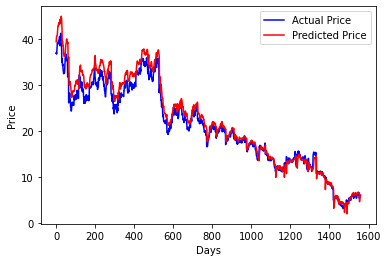

In [17]:
model.eval()
plot_graph(data, "TRAIN")

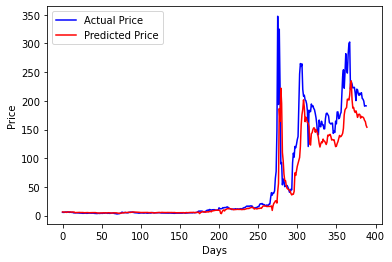

In [18]:
model.eval()
plot_graph(data, "TEST")